# Creating the same Time Series model, with the use of categories to produce a more accurate forecast

## This model was created with the same steps as the "TimeSeriesForecastTry-XGBoost" notebook, but the dataset that was used is different.
## Here the data was split into categories, to examine the "Women" products forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

C:\Users\hasan\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('Womens_NetGrossProfit.csv')
df = df.set_index('Transaction Date')
df.index = pd.to_datetime(df.index)

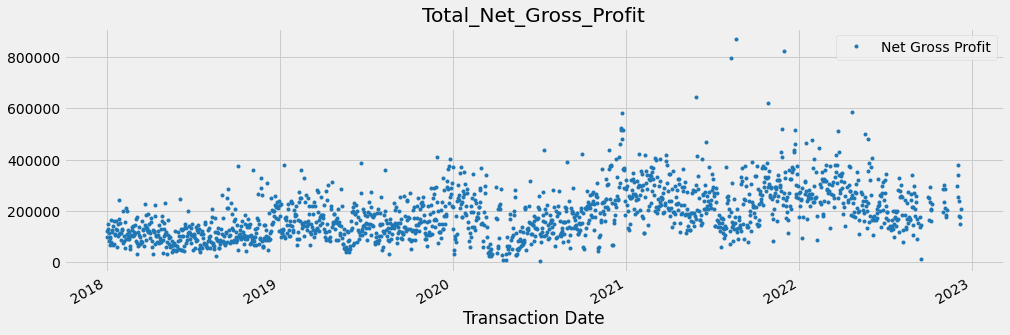

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Total_Net_Gross_Profit')
plt.show()

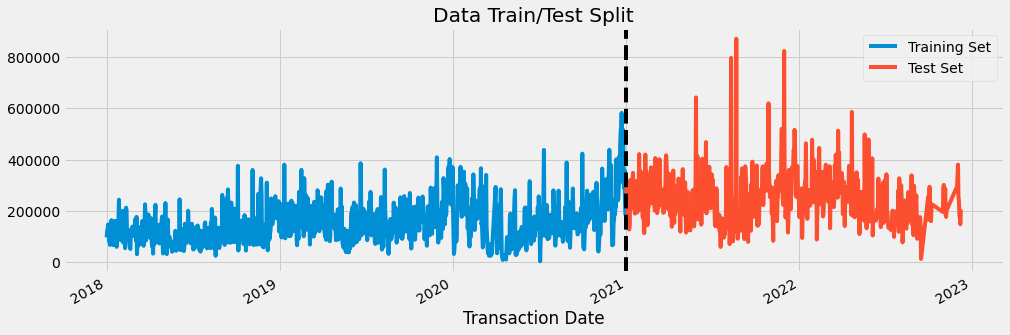

In [5]:
train = df.loc[df.index < '01-01-2021']
test = df.loc[df.index >= '01-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

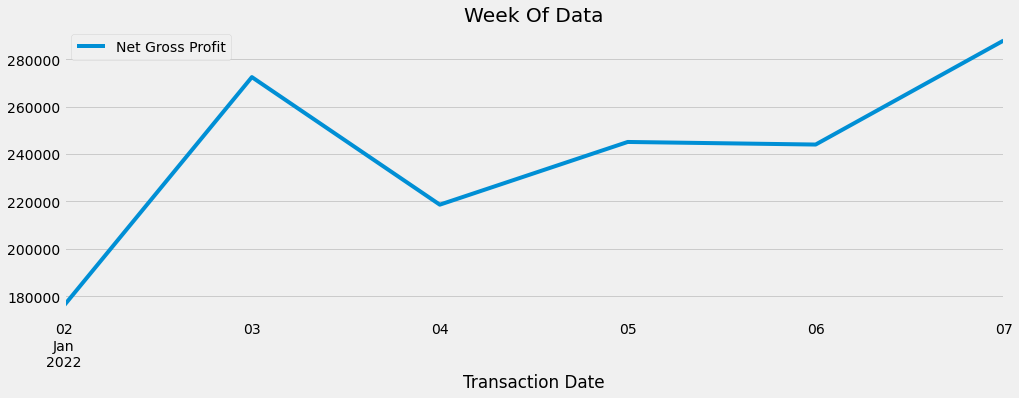

In [6]:
df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

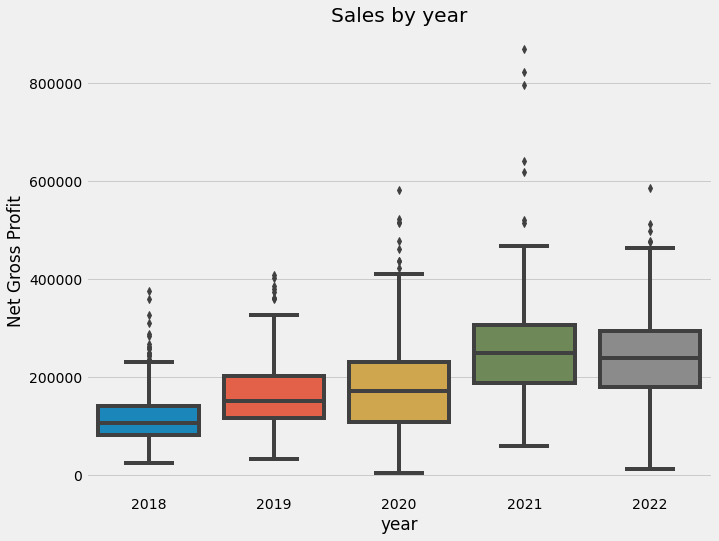

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='Net Gross Profit')
ax.set_title('Sales by year')
plt.show()

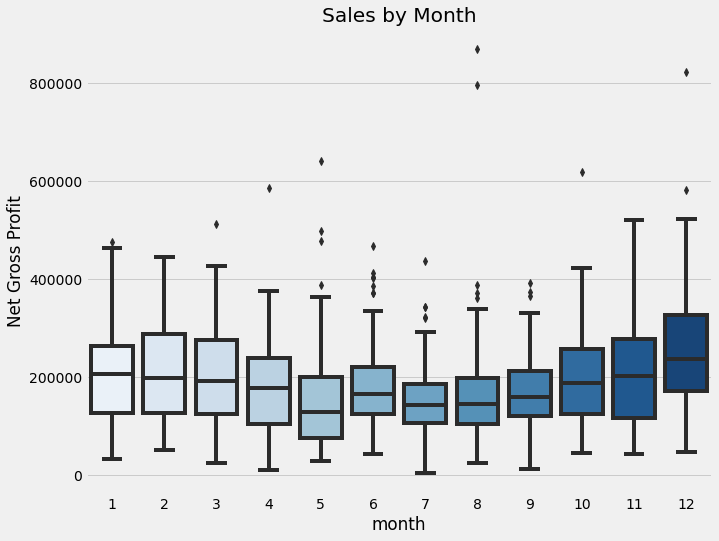

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Net Gross Profit', palette='Blues')
ax.set_title('Sales by Month')
plt.show()

In [15]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Net Gross Profit'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[09:35:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:171512.69380	validation_1-rmse:266185.37714
[100]	validation_0-rmse:87809.47436	validation_1-rmse:170306.66333
[200]	validation_0-rmse:66171.22091	validation_1-rmse:138521.07260
[300]	validation_0-rmse:60825.05467	validation_1-rmse:127785.45549
[400]	validation_0-rmse:58566.45225	validation_1-rmse:123736.34803
[500]	validation_0-rmse:57343.48438	validation_1-rmse:122522.73886
[600]	validation_0-rmse:56131.89277	validation_1-rmse:122152.25173
[675]	validation_0-rmse:55318.00792	validation_1-rmse:122064.39941


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

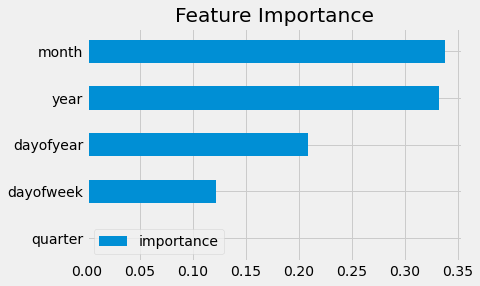

In [17]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

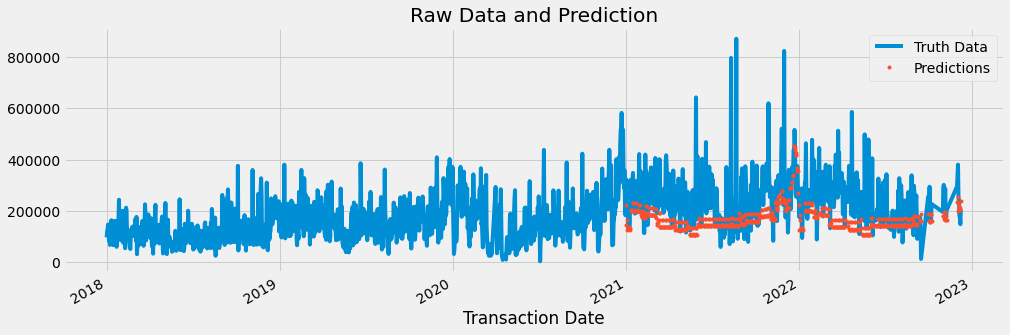

In [18]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Net Gross Profit']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

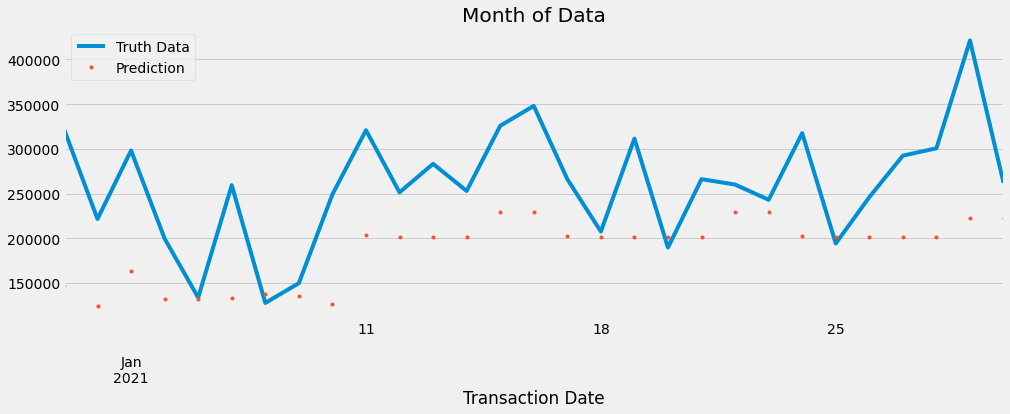

In [20]:


ax = df.loc[(df.index > '01-01-2021') & (df.index < '31-01-2021')]['Net Gross Profit'] \
    .plot(figsize=(15, 5), title='Month of Data')
df.loc[(df.index > '01-01-2021') & (df.index < '31-01-2021')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()



In [21]:
score = np.sqrt(mean_squared_error(test['Net Gross Profit'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 122048.86


In [22]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2021-08-22    726634.244614
2021-08-11    648225.678128
2021-12-01    585712.784675
2021-05-29    507516.473497
2022-04-23    429520.253669
2021-10-29    409246.803691
2022-05-20    363620.080316
2022-03-25    346212.545558
2022-05-28    343945.555816
2021-06-19    298379.849129
Name: error, dtype: float64

<AxesSubplot:ylabel='Frequency'>

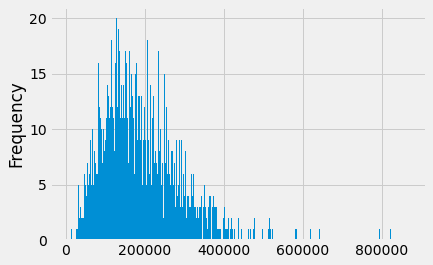

In [23]:
df['Net Gross Profit'].plot(kind='hist', bins=500)

In [24]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=365*1, gap=1)
df = df.sort_index()



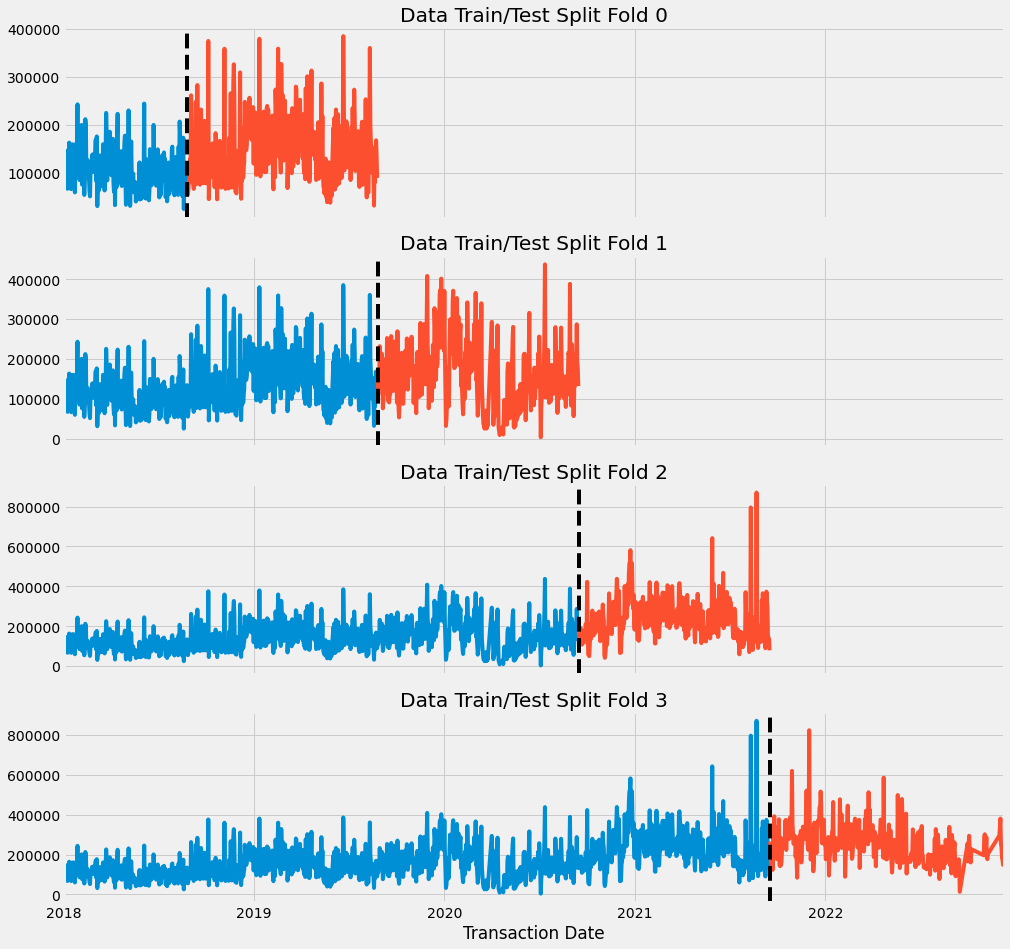

In [26]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Net Gross Profit'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Net Gross Profit'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [27]:
def add_lags(df):
    target_map = df['Net Gross Profit'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('546 days')).map(target_map)
    return df

In [28]:
df = add_lags(df)

In [29]:
tss = TimeSeriesSplit(n_splits=4, test_size=365*1, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2']
    TARGET = 'Net Gross Profit'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[09:37:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:114062.53540	validation_1-rmse:161837.69226
[100]	validation_0-rmse:54532.65171	validation_1-rmse:105292.72671
[200]	validation_0-rmse:37918.18565	validation_1-rmse:86558.55664
[300]	validation_0-rmse:33271.81822	validation_1-rmse:79920.76370
[400]	validation_0-rmse:31446.62682	validation_1-rmse:77448.68235
[500]	validation_0-rmse:30114.39383	validation_1-rmse:76178.11669
[600]	validation_0-rmse:28833.66762	validation_1-rmse:75637.52138
[700]	validation_0-rmse:27626.46241	validation_1-rmse:75326.87813
[800]	validation_0-rmse:26623.78539	validation_1-rmse:75178.24489
[900]	validation_0-rmse:25766.60421	validation_1-rmse:74963.86677
[999]	validation_0-rmse:25121.36242	validation_1-rmse:74826.25980
[09:37:10] WARNING: C:/buildkite-agent/bui

In [30]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 91649.0253
Fold scores:[74826.2592905321, 80090.14666236307, 125291.58782500356, 86388.10722937094]


In [31]:
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2']
TARGET = 'Net Gross Profit'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=650,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[09:37:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:210936.12988
[100]	validation_0-rmse:103697.48364
[200]	validation_0-rmse:76207.55258
[300]	validation_0-rmse:69638.91104
[400]	validation_0-rmse:67454.95201
[500]	validation_0-rmse:66140.04904
[600]	validation_0-rmse:65103.94231
[649]	validation_0-rmse:64661.52800


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=650, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [32]:
df.index.max()

Timestamp('2022-12-09 00:00:00')

In [33]:
future = pd.date_range('2022-12-09','2023-12-09', freq='24h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [34]:
future_w_features = df_and_future.query('isFuture').copy()

In [35]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

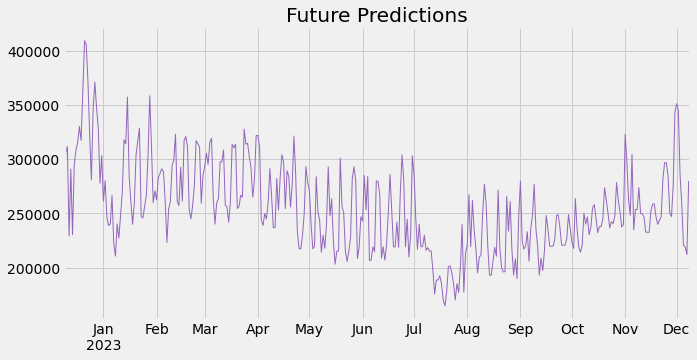

In [36]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [37]:
future_w_features

,Net Gross Profit,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,hour,prediction,lag1,lag2,isFuture,pred
2022-12-09,NaN,4,4,12,2022,343,9,49,NaN,NaN,163289.960853,402954.433088,True,217066.687500
2022-12-10,NaN,5,4,12,2022,344,10,49,NaN,NaN,359891.494377,264736.168460,True,305787.250000
2022-12-11,NaN,6,4,12,2022,345,11,49,NaN,NaN,271537.027693,260663.541685,True,311591.437500
2022-12-12,NaN,0,4,12,2022,346,12,50,NaN,NaN,218789.236895,208305.036014,True,229169.609375
2022-12-13,NaN,1,4,12,2022,347,13,50,NaN,NaN,322695.381484,239353.526215,True,290951.593750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05,NaN,1,4,12,2023,339,5,49,NaN,NaN,181881.968944,176393.643395,True,220597.390625
2023-12-06,NaN,2,4,12,2023,340,6,49,NaN,NaN,174674.782335,181583.185684,True,219133.421875
2023-12-07,NaN,3,4,12,2023,341,7,49,NaN,NaN,148339.848566,165363.808367,True,212090.546875
2023-12-08,NaN,4,4,12,2023,342,8,49,NaN,NaN,NaN,NaN,True,279612.406250


In [52]:
col1 = future_w_features['pred']
Prediction_df = pd.DataFrame({'Net Gross Profit': col1})

Prediction_df

,Net Gross Profit
2022-12-09,217066.687500
2022-12-10,305787.250000
2022-12-11,311591.437500
2022-12-12,229169.609375
2022-12-13,290951.593750
...,...
2023-12-05,220597.390625
2023-12-06,219133.421875
2023-12-07,212090.546875
2023-12-08,279612.406250


In [53]:
Historical_Pred_df = pd.concat([df, Prediction_df], axis=0)

In [54]:
Historical_Pred_df

,Net Gross Profit,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,hour,prediction,lag1,lag2,isFuture
2018-01-01,97352.812009,0.0,1.0,1.0,2018.0,1.0,1.0,1,0.0,NaN,NaN,NaN,False
2018-01-02,120304.480854,1.0,1.0,1.0,2018.0,2.0,2.0,1,0.0,NaN,NaN,NaN,False
2018-01-03,128284.846298,2.0,1.0,1.0,2018.0,3.0,3.0,1,0.0,NaN,NaN,NaN,False
2018-01-04,147307.618101,3.0,1.0,1.0,2018.0,4.0,4.0,1,0.0,NaN,NaN,NaN,False
2018-01-05,113720.743690,4.0,1.0,1.0,2018.0,5.0,5.0,1,0.0,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05,220597.390625,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
2023-12-06,219133.421875,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
2023-12-07,212090.546875,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
2023-12-08,279612.406250,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN


In [55]:
Historical_Pred_df = Historical_Pred_df[['Net Gross Profit']]

In [56]:
Historical_Pred_df

,Net Gross Profit
2018-01-01,97352.812009
2018-01-02,120304.480854
2018-01-03,128284.846298
2018-01-04,147307.618101
2018-01-05,113720.743690
...,...
2023-12-05,220597.390625
2023-12-06,219133.421875
2023-12-07,212090.546875
2023-12-08,279612.406250


In [69]:
Historical_Pred_df.rename_axis("Transaction Date", axis=0, inplace=True)

In [70]:
Historical_Pred_df.to_csv('Womens_Historical_Pred_df_NetGrossProfit.csv', index=True)

In [73]:
df_Prediction = pd.read_csv('Womens_Historical_Pred_df_NetGrossProfit.csv')
df_Prediction = df_Prediction.set_index('Transaction Date')
df_Prediction.index = pd.to_datetime(df_Prediction.index)

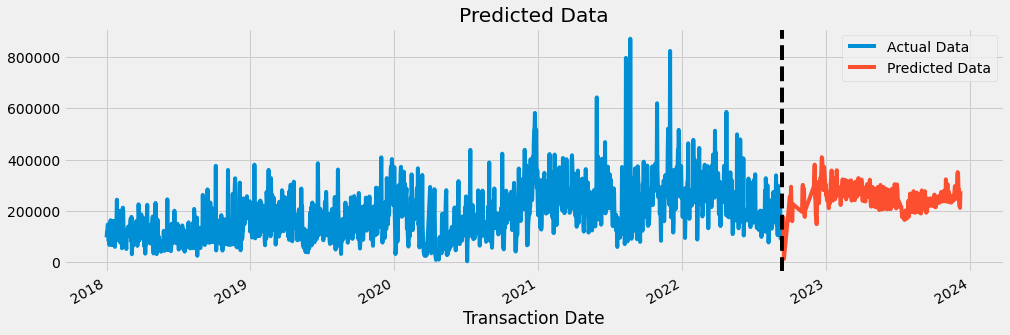

In [81]:
Actual = Historical_Pred_df.loc[df_Prediction.index < '09-12-2022']
Prediction = Historical_Pred_df.loc[df_Prediction.index >= '9-12-2022']

fig, ax = plt.subplots(figsize=(15, 5))
Actual.plot(ax=ax, label='Actual Data', title='Predicted Data')
Prediction.plot(ax=ax, label='Predicted Data')
ax.axvline('09-12-2022', color='black', ls='--')
ax.legend(['Actual Data', 'Predicted Data'])
plt.show()